In [ ]:
!pip install orbit-ml
!pip install prophet
!pip install sktime[all_extras]

# таблички, матрицы и статистические штучки
import pandas as pd 
import numpy as np
import numpy.linalg 
from scipy import stats
# графики
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# временные ряды
import sktime
import statsmodels.api as sm
from sktime.forecasting.model_selection import temporal_train_test_split, ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from sklearn.metrics import mean_absolute_error as MAE
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

### 1. Взять языка
Месячный ряд возьмем из sophist.hse, для этого с помощью пакета ББ в R импортируем временной ряд, показываюший среднюю номинальную заработную плату в России.


In [ ]:
# волшебная команда, которая позволит в колабе писать код на R
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("devtools")
devtools::install_github("bdemeshev/sophisthse")
library(sophisthse)
df <- sophisthse("WAG_C_M")
write.csv(df, 'wag.csv')

Импортируем данные в pandas, поменяем формат индекса и разобьем на трейн и тест:

In [19]:
ts = pd.read_csv('wag.csv')
ts.index = pd.date_range(start = "1993-01-01", periods=len(ts), freq="M") 
ts = pd.DataFrame(ts['WAG_C_M'])
ts_train, ts_test = temporal_train_test_split(ts, test_size = 12)

### 2. Намалевич

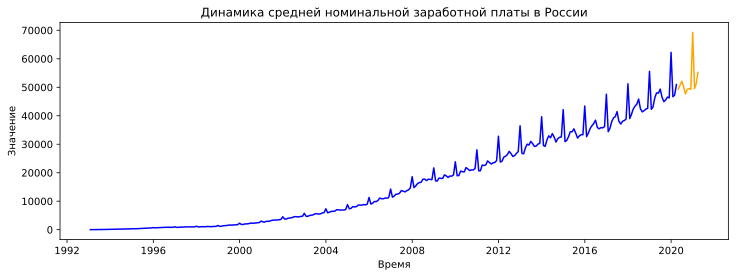

In [103]:
plt.figure(figsize=(12, 4))
plt.plot(ts_train['WAG_C_M'], color = 'blue')
plt.plot(ts_test['WAG_C_M'], color = 'orange')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.title('Динамика средней номинальной заработной платы в России')
plt.show()

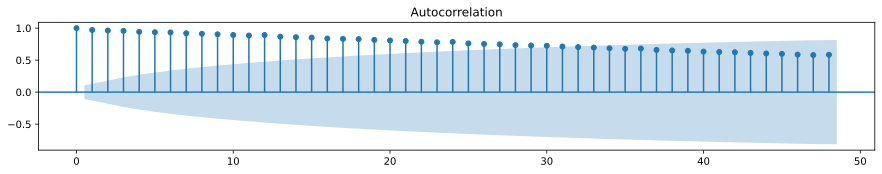

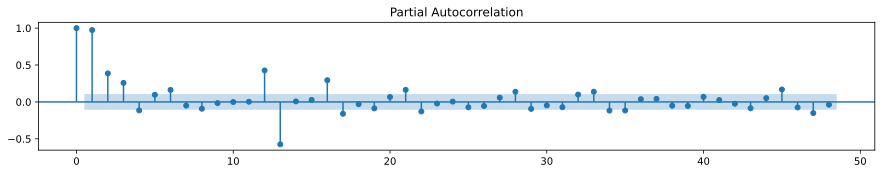

In [104]:
plt.figure(figsize = (15,8))
ax = plt.subplot(313)
sm.graphics.tsa.plot_acf(ts.WAG_C_M.values.squeeze(), lags=48, ax=ax)
plt.show()
plt.figure(figsize = (15,8))
ax = plt.subplot(311)
sm.graphics.tsa.plot_pacf(ts.WAG_C_M.values.squeeze(), lags=48, ax=ax)
plt.show()

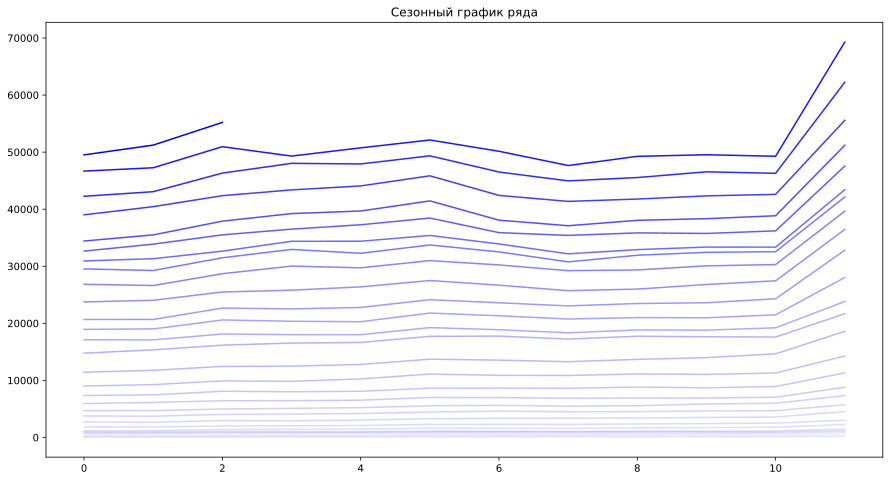

In [94]:
plt.figure(figsize = (15, 8))
for year in np.unique(ts.index.year):
    plt.plot(ts[ts.index.year == year].values, alpha = (1/np.sqrt(1.2)) ** (2021 - year), color = 'blue')
plt.title('Сезонный график ряда')
plt.show()

### 3. Твиттер
Комментарии по поводу графика:
- Сезонность четко выражена, каждый декабрь наблюдается годовой пик (так как в это же время начисляются премии, компенсации и все остальное), в январе резкое падение и небольшой рост к лету.
- Тренд экспоненциальный, так как мы взяли номинальный показатель
- Ряд нестационарен, так как дисперсия возрастает со временем, к тому же наблюдается тренд и сезонность
- Точек излома нет, с течением времени сезонность стала более выраженной
- Амплитуда колебаний ряда растет, но ряд не будем логарифмировать, так как все модели, кроме SARIMA, могут работать с нестационарными рядами напрямую (а модели SARIMA перед этим дифференцируют ряды)

### 4. Двенадцать месяцев
Модели

In [23]:
# создадим табличку для записи результатов
ts_results = pd.DataFrame(columns = ['Model', 'test MAE'])

In [24]:
# Создаем массив для предсказывания
fh = ForecastingHorizon(ts_test.index, is_relative=False)
# Наивная модель 
NaiveForecaster1 = NaiveForecaster(strategy = 'last', sp = 1)
NaiveForecaster1.fit(ts_train['WAG_C_M'])
pred1 = NaiveForecaster1.predict(fh)
# Сезонная наивная модель
NaiveForecaster2 = NaiveForecaster(strategy = 'last', sp = 12)
NaiveForecaster2.fit(ts_train['WAG_C_M'])
pred2 = NaiveForecaster2.predict(fh)
# Заносим результаты в табличку
ts_results = ts_results.append({'Model': 'Naive Forecaster', 'test MAE': np.round(MAE(ts_test['WAG_C_M'], pred1), 2)}, ignore_index = True)
ts_results = ts_results.append({'Model': 'Naive Forecaster (with seasonality)', 'test MAE': np.round(MAE(ts_test['WAG_C_M'], pred2), 2)}, ignore_index = True)

In [ ]:
# SARIMA(1, 1, 1)(1, 1, 0)[12]
arima1 = ARIMA(order = (1, 1, 1), seasonal_order = (1, 1, 0, 12))
arima1.fit(ts_train['WAG_C_M'])
pred3 = arima1.predict(fh)
# Алгоритм Хиндмана-Хандакара автоматического подбора SARIMA
arima2 = AutoARIMA(start_p=1, d=1, start_q=0, 
                   max_p=3, max_d=1, max_q=2, 
                   start_P=0, D = 1, start_Q=0, 
                   max_P=2, max_D=1, max_Q=2, 
                   sp=12, suppress_warnings=True, stepwise=False, n_jobs=-1, maxiter = 20)
arima2.fit(ts_train['WAG_C_M'])
pred4 = arima2.predict(fh)
# Заносим результаты в табличку
ts_results = ts_results.append({'Model': 'SARIMA(1, 1, 1)(1, 1, 0)[12]', 'test MAE': np.round(MAE(ts_test['WAG_C_M'], pred3), 2)}, ignore_index = True)
ts_results = ts_results.append({'Model': 'AutoARIMA', 'test MAE': np.round(MAE(ts_test['WAG_C_M'], pred4), 2)}, ignore_index = True)

In [26]:
ts_ets_train = ts_train.copy()
ts_ets_train.index = pd.PeriodIndex(ts_ets_train.index)
ts_ets_test = ts_test.copy()
ts_ets_test.index = pd.PeriodIndex(ts_ets_test.index)

fh = ForecastingHorizon(ts_ets_test.index, is_relative=False)

exp = ExponentialSmoothing(trend='add', seasonal='additive', sp = 12)
exp.fit(ts_ets_train['WAG_C_M'])
pred5 = exp.predict(fh)
ets = AutoETS(auto=True, n_jobs=-1, allow_multiplicative_trend = True, sp = 12)
ets.fit(ts_ets_train['WAG_C_M'])
pred6 = ets.predict(fh)
ts_results = ts_results.append({'Model': 'ETS(AAA)', 'test MAE': np.round(MAE(ts_test['WAG_C_M'], pred5), 2)}, ignore_index = True)
ts_results = ts_results.append({'Model': 'AutoETS', 'test MAE': np.round(MAE(ts_test['WAG_C_M'], pred6), 2)}, ignore_index = True)

Итоговая табличка с ошибками моделей:

In [27]:
ts_results

,Model,test MAE
0,Naive Forecaster,3016.25
1,Naive Forecaster (with seasonality),3417.17
2,"SARIMA(1, 1, 1)(1, 1, 0)[12]",1660.05
3,AutoARIMA,1552.07
4,ETS(AAA),1292.74
5,AutoETS,916.57


#### Бонус: кросс-валидация моделей

Мы захотели получить бонусные баллы, поэтому заодно запилили кросс-валидацию моделей. Для сравнения мы будем брать среднее из MAE для моделей, и медиану.

In [28]:
cv_results = pd.DataFrame(columns = ['Model', 'cv MAE (Mean)', 'cv MAE (Median)'])

Для каждой из моделей проведем кросс-валидацию с помощью расширяющегося окна.

Предупреждение: кросс-валидация AutoARIMA занимает около полутора часов!

In [29]:
forecaster = NaiveForecaster(strategy = 'last', sp = 1)
cv = ExpandingWindowSplitter(
    step_length=1, fh=[1], initial_window=272
)
frame = evaluate(forecaster=forecaster, y=ts['WAG_C_M'], cv=cv, strategy="refit", scoring = MeanAbsoluteError(), return_data=True)
cv_results = cv_results.append({'Model': 'Naive Forecaster', 
                                'cv MAE (Mean)': np.round(np.mean(frame['test_MeanAbsoluteError']), 2),
                                'cv MAE (Median)': np.round(np.median(frame['test_MeanAbsoluteError']), 2)}, ignore_index = True)

In [30]:
forecaster = NaiveForecaster(strategy = 'last', sp = 12)
cv = ExpandingWindowSplitter(
    step_length=1, fh=[1], initial_window=272
)
frame = evaluate(forecaster=forecaster, y=ts['WAG_C_M'], cv=cv, strategy="refit", scoring = MeanAbsoluteError(), return_data=True)
cv_results = cv_results.append({'Model': 'Naive Forecaster (with seasonality)', 
                                'cv MAE (Mean)': np.round(np.mean(frame['test_MeanAbsoluteError']), 2),
                                'cv MAE (Median)': np.round(np.median(frame['test_MeanAbsoluteError']), 2)}, ignore_index = True)

In [31]:
forecaster = ARIMA(order = (1, 1, 1), seasonal_order = (1, 1, 0, 12))
cv = ExpandingWindowSplitter(
    step_length=1, fh=[1], initial_window=272
)
frame = evaluate(forecaster=forecaster, y=ts['WAG_C_M'], cv=cv, strategy="refit", scoring = MeanAbsoluteError(), return_data=True)
cv_results = cv_results.append({'Model': 'SARIMA(1, 1, 1)(1, 1, 0)[12]', 
                                'cv MAE (Mean)': np.round(np.mean(frame['test_MeanAbsoluteError']), 2),
                                'cv MAE (Median)': np.round(np.median(frame['test_MeanAbsoluteError']), 2)}, ignore_index = True)

In [ ]:
forecaster = AutoARIMA(start_p=1, d=1, start_q=0, 
                   max_p=3, max_d=1, max_q=2, 
                   start_P=0, D = 1, start_Q=0, 
                   max_P=2, max_D=1, max_Q=2, 
                   sp=12, suppress_warnings=True, stepwise=False, n_jobs=-1, maxiter = 20)
cv = ExpandingWindowSplitter(
    step_length=1, fh=[1], initial_window=272
)
frame = evaluate(forecaster=forecaster, y=ts['WAG_C_M'], cv=cv, strategy="refit", scoring = MeanAbsoluteError(), return_data=True)
cv_results = cv_results.append({'Model': 'AutoARIMA', 
                                'cv MAE (Mean)': np.round(np.mean(frame['test_MeanAbsoluteError']), 2),
                                'cv MAE (Median)': np.round(np.median(frame['test_MeanAbsoluteError']), 2)}, ignore_index = True)

In [ ]:
ts_ets = ts.copy()
ts_ets.index = pd.PeriodIndex(ts_ets.index)
forecaster = ExponentialSmoothing(trend='add', seasonal='additive', sp = 12)
cv = ExpandingWindowSplitter(
    step_length=1, fh=[1], initial_window=272
)
frame = evaluate(forecaster=forecaster, y=ts_ets['WAG_C_M'], cv=cv, strategy="refit", scoring = MeanAbsoluteError(), return_data=True)
cv_results = cv_results.append({'Model': 'ETS(AAA)', 
                                'cv MAE (Mean)': np.round(np.mean(frame['test_MeanAbsoluteError']), 2),
                                'cv MAE (Median)': np.round(np.median(frame['test_MeanAbsoluteError']), 2)}, ignore_index = True)

In [36]:
forecaster = AutoETS(auto=True, n_jobs=-1, allow_multiplicative_trend = True, sp = 12)
cv = ExpandingWindowSplitter(
    step_length=1, fh=[1], initial_window=272
)
frame = evaluate(forecaster=forecaster, y=ts_ets['WAG_C_M'], cv=cv, strategy="refit", scoring = MeanAbsoluteError(), return_data=True)
cv_results = cv_results.append({'Model': 'AutoETS', 
                                'cv MAE (Mean)': np.round(np.mean(frame['test_MeanAbsoluteError']), 2),
                                'cv MAE (Median)': np.round(np.median(frame['test_MeanAbsoluteError']), 2)}, ignore_index = True)

Результаты кросс-валидации:

In [37]:
cv_results

,Model,cv MAE (Mean),cv MAE (Median)
0,Naive Forecaster,3562.09,1422.00
1,Naive Forecaster (with seasonality),3270.12,3229.00
2,"SARIMA(1, 1, 1)(1, 1, 0)[12]",705.41,453.87
3,AutoARIMA,668.26,489.84
4,ETS(AAA),666.36,443.08
5,AutoETS,784.93,548.53


### 5. Кто на свете всех милее?

Лучшей моделью оказалась AutoETS (по MAE для тестовой выборки) и ETS(AAA) (по MAE при кросс-валидации)

In [42]:
fh = ForecastingHorizon(pd.PeriodIndex(pd.date_range(start = "2021-04-01", periods=12, freq="M")), is_relative=False)
ts_ets = ts.copy()
ts_ets.index = pd.PeriodIndex(ts_ets.index)
autoets = AutoETS(auto=True, n_jobs=-1, allow_multiplicative_trend = True, sp = 12)
autoets.fit(ts_ets['WAG_C_M'])
pred1 = autoets.predict(fh)
exp = ExponentialSmoothing(trend='add', seasonal='additive', sp = 12)
exp.fit(ts_ets['WAG_C_M'])
pred2 = exp.predict(fh)

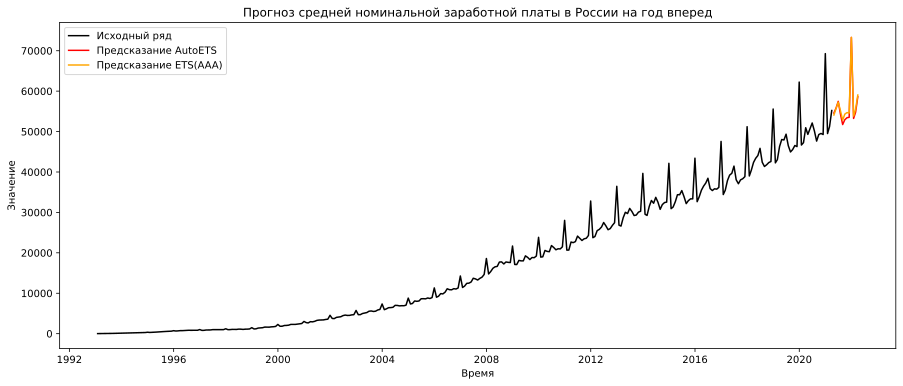

In [96]:
plt.figure(figsize=(15, 6))
plt.plot(ts['WAG_C_M'], color = 'black', label = 'Исходный ряд')
plt.plot(pred1, color = 'red', label = 'Предсказание AutoETS')
plt.plot(pred2, color = 'orange', label = 'Предсказание ETS(AAA)')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.title('Прогноз средней номинальной заработной платы в России на год вперед')
plt.legend()
plt.show()

### 6. Хождение в народ

In [56]:
df = pd.read_stata('https://github.com/1grigoryan/rlms/blob/main/USER_RLMS-HSE_IND_1994_2019_v2_rus.dta?raw=true')

Предобработка датасета:

In [57]:
df.dropna(inplace = True)
df = df[df['J10'] != 'ЗАТРУДНЯЮСЬ ОТВЕТИТЬ']
df = df[df['J10'] != 'НЕТ ОТВЕТА']
df = df[df['J10'] != 'ОТКАЗ ОТ ОТВЕТА']
df = df[df['J69_8A'] != 'ЗAТРУДНЯЮCЬ ОТВЕТИТЬ']
df = df[df['J69_8A'] != 'НЕТ ОТВЕТA']
df = df[df['J69_8A'] != 'ОТКAЗ ОТ ОТВЕТA']
df = df[df['J69_8A'] != 'ЧЕМ БОЛЬШЕ, ТЕМ ЛУЧШЕ, ОЧЕНЬ МНОГО']
df.reset_index(inplace = True, drop = True)
df = df.rename(columns = {'status': 'type', 'J10': 'wage', 'J69_8A': 'nls'})
df['type'] = df['type'].replace({'Областной центр': 1, 'Город': 2, 'ПГТ': 3, 'Село': 4})
df['wage'] = df['wage'].astype('int64')
df['nls'] = df['nls'].astype('int64')

Удалим из датасета всех тех, кто указывает доход для нормального уровня жизни меньший, чем заработную плату, а так же выбросы по NLS (NLS - Normal Living Standards, это переменная, показывающая доход для нормального уровня жизни)

In [58]:
df = df[(df['nls'] - df['wage'] >= 0)]
df = df[df['nls'] < 1000000]
df.reset_index(inplace = True, drop = True)
df

,idind,year,type,wage,nls
0,1,1998,3,294,3000
1,2,1998,3,1416,5000
2,3,1998,3,950,10000
3,7,1998,3,188,2000
4,8,1998,3,1200,3000
...,...,...,...,...,...
14286,20004,2002,1,3700,30000
14287,20005,2002,1,3000,15000
14288,21438,2002,1,2700,15000
14289,20011,2002,1,1500,18000


In [59]:
df['logwage'] = np.log(df['wage'])
df['lognls'] = np.log(df['nls'])

### 7. Кому на Руси жить хорошо?

Исследовательский вопрос: "Как на представления о доходе, необходимом для нормального уровня жизни, влияют заработная плата респондента и тип населенного пункта, в котором проживает респондент?"

### 8. Сделай красиво!

In [97]:
fig = make_subplots(rows = 2, cols=2, subplot_titles=("Заработная плата до логарифмирования", 
                                                      "Заработная плата после логарифмирования", 
                                                      "Нормальный уровень дохода до логарифмирования", 
                                                      "Нормальный уровень дохода после логарифмирования"))
trace0 = go.Histogram(x=df["wage"].values, y=df.index)
trace1 = go.Histogram(x=df["logwage"].values, y=df.index, nbinsx=100)
trace2 = go.Histogram(x=df['nls'].values, y=df.index)
trace3 = go.Histogram(x=df["lognls"].values, y=df.index, nbinsx=100)

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 2, 2)

fig.update_layout(showlegend=False, height=800, title_text="Почему логарифмирование нужно")
fig.show()

Как мы видим, логарифмирование нужно, так как лучше работать с нормально распределенными переменными, а наши переменные имели изначально лог-нормальное распределение.

In [62]:
df1 = df.copy()
df1 = df1.sort_values(by = 'type')
df1['type'] =  df1['type'].replace({1: 'Областной центр', 2: 'Город', 3: 'ПГТ', 4: 'Село'})
fig = px.box(df1, x="type", y="lognls")
fig.update_layout(title_text="Распределение логарифма нормального уровня дохода по типу населенного пункта",
                  xaxis_title = "Тип населенного пункта",
                  yaxis_title = "Логарифм нормального уровня дохода")
fig.show()

Из данного графика следует, что мы можем сделать переменную "Тип населенного пункта" ordered, а не вводить в датасет 3 дамми-переменные (так как 4 будет иначе с ними строго коррелирована), так как логарифм нормального уровня дохода, в среднем, падает от областного центра к селу.

In [63]:
df2 = df.copy()
df2['year'] = df2['year'].astype('str')
fig = px.scatter(df2, x="lognls", y="logwage", color="year", width=1100, height=550,
                 color_discrete_sequence=["#4d5198", "#65a1bf", "#8fcf94", "#ffcce7"], 
                 title="Зависимость логарифма нормального уровня дохода от логарифма зарплаты", 
                 labels={
                     "lognls": "Логарифм нормального уровня дохода",
                     "logwage": "Логарифм зарплаты",
                     "year": "Год"}) 

fig.update_traces(marker=dict(size=7),
                  selector=dict(mode='markers'))

fig.show()

Тут мы видим положительную линейную корреляцию между зависимой переменной и регрессором, значит, мы можем оценить модели с помощью библиотеки plm в R.

### 9. Три сестры

Сами модели мы оценим в R, поэтому сохраним датасет как файл csv, и запустим уже ячейки R. 

In [64]:
df.to_csv('RLMS.csv', index = False)

In [65]:
%%R
data <- read.csv("RLMS.csv")

Установим библиотеку для работы с панельными данными.

In [ ]:
%%R
install.packages('plm')
library(plm)

Теперь объявим наши данные панельными, сделав столбцы с id респондента и годом индексами

In [80]:
%%R
data <- pdata.frame(data, index = c("idind", "year"), row.names = TRUE)

Оценим наши три модели

In [81]:
%%R
pooled <- plm(lognls ~ 1 + type + logwage, data = data, model = "pooling")
fixed_effects <- plm(lognls ~ 1 + type + logwage, data = data, model = "within")
random_effects <- plm(lognls ~ 1 + type + logwage, data = data, model = "random")

И посмотрим на краткое summary каждой

In [82]:
%%R
summary(pooled)

Pooling Model

Call:
plm(formula = lognls ~ 1 + type + logwage, data = data, model = "pooling")

Unbalanced Panel: n = 6787, T = 1-4, N = 14291

Residuals:
     Min.   1st Qu.    Median   3rd Qu.      Max. 
-2.354723 -0.467699 -0.044085  0.406441  5.551887 

Coefficients:
              Estimate Std. Error t-value  Pr(>|t|)    
(Intercept)  6.1890250  0.0455849 135.769 < 2.2e-16 ***
type        -0.0778052  0.0055374 -14.051 < 2.2e-16 ***
logwage      0.4492269  0.0056879  78.980 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    11184
Residual Sum of Squares: 7379.6
R-Squared:      0.34016
Adj. R-Squared: 0.34007
F-statistic: 3682.86 on 2 and 14288 DF, p-value: < 2.22e-16


In [83]:
%%R
summary(fixed_effects)

Oneway (individual) effect Within Model

Call:
plm(formula = lognls ~ 1 + type + logwage, data = data, model = "within")

Unbalanced Panel: n = 6787, T = 1-4, N = 14291

Residuals:
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-2.56990 -0.19488  0.00000  0.19970  4.24335 

Coefficients:
         Estimate Std. Error t-value  Pr(>|t|)    
logwage 0.4460318  0.0078633  56.724 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    3438.8
Residual Sum of Squares: 2406.7
R-Squared:      0.30013
Adj. R-Squared: -0.33295
F-statistic: 3217.55 on 1 and 7503 DF, p-value: < 2.22e-16


In [84]:
%%R
summary(random_effects)

Oneway (individual) effect Random Effect Model 
   (Swamy-Arora's transformation)

Call:
plm(formula = lognls ~ 1 + type + logwage, data = data, model = "random")

Unbalanced Panel: n = 6787, T = 1-4, N = 14291

Effects:
                 var std.dev share
idiosyncratic 0.3208  0.5664 0.621
individual    0.1958  0.4425 0.379
theta:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2120  0.3290  0.4057  0.3659  0.4610  0.4610 

Residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.1454 -0.3703 -0.0398 -0.0050  0.3236  4.9313 

Coefficients:
              Estimate Std. Error z-value  Pr(>|z|)    
(Intercept)  6.1921964  0.0464487 133.313 < 2.2e-16 ***
type        -0.0831557  0.0067809 -12.263 < 2.2e-16 ***
logwage      0.4523854  0.0056808  79.635 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    17306
Residual Sum of Squares: 4648.1
R-Squared:      0.73233
Adj. R-Squared: 0.73229
Chisq: 7173.55 on 2 DF, p-value: < 2.22e-

Теперь сравним модели. Сначала сравним PooledOLS и модель с фиксированными эффектами с помощью F-теста

In [85]:
%%R
pFtest(fixed_effects, pooled)


	F test for individual effects

data:  lognls ~ 1 + type + logwage
F = 2.2849, df1 = 6785, df2 = 7503, p-value < 2.2e-16
alternative hypothesis: significant effects



Согласно данному теству, мы отвергаем нулевую гипотезу о незначимости индивидуальных эффектов, то есть мы выбираем FE.

Теперь сравним FE и RE с помощью теста Хаусмана:

In [88]:
%%R
phtest(fixed_effects, random_effects)


	Hausman Test

data:  lognls ~ 1 + type + logwage
chisq = 1.3657, df = 1, p-value = 0.2426
alternative hypothesis: one model is inconsistent



Тут мы не можем опровергнуть нулевую гипотезу о том, что FE и RE оценки статистически не отличаются друг от друга, поэтому мы выбираем RE.

И наконец, сравним RE и Pooled OLS с помощью теста Бройша-Пагана:

In [87]:
%%R
plmtest(random_effects,  type = "bp")


	Lagrange Multiplier Test - (Breusch-Pagan) for unbalanced panels

data:  lognls ~ 1 + type + logwage
chisq = 1292.3, df = 1, p-value < 2.2e-16
alternative hypothesis: significant effects



Мы отвергаем нулевую гипотезу о незначимых эффектах в RE, значит, мы выбираем RE как лучшую из трех моделей.

### 10. Ответ на главный вопрос

Ответ на наш исследовательский вопрос можно представить следующим образом: статистически значимая взаимосвязь между логарифмом представлений о нормальном уровне дохода и логарифмом заработной платы респондента есть, так же такая связь присутствует между логарифмом представлений о нормальном уровне дохода и типом населенного пункта, в которой проживает респондент. В среднем, при увеличении заработной платы на 1% представление о нормальном уровне дохода растет на 0,45%, так же представления о нормальном уровне дохода выше в областном центре и городе, чем в ПГТ и селах. 

Конечно, говорить о причинно-следственной связи мы не можем, так как для этого нужно вводить контрольные переменные, и теоретически обосновать возможность наличия казуальной связи, но мы показали, что у людей, в среднем, тем выше ожидания по поводу нормального уровня жизни, чем выше у них заработная плата, что кажется вполне закономерным.

In [89]:
%%R
summary(random_effects)

Oneway (individual) effect Random Effect Model 
   (Swamy-Arora's transformation)

Call:
plm(formula = lognls ~ 1 + type + logwage, data = data, model = "random")

Unbalanced Panel: n = 6787, T = 1-4, N = 14291

Effects:
                 var std.dev share
idiosyncratic 0.3208  0.5664 0.621
individual    0.1958  0.4425 0.379
theta:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2120  0.3290  0.4057  0.3659  0.4610  0.4610 

Residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.1454 -0.3703 -0.0398 -0.0050  0.3236  4.9313 

Coefficients:
              Estimate Std. Error z-value  Pr(>|z|)    
(Intercept)  6.1921964  0.0464487 133.313 < 2.2e-16 ***
type        -0.0831557  0.0067809 -12.263 < 2.2e-16 ***
logwage      0.4523854  0.0056808  79.635 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    17306
Residual Sum of Squares: 4648.1
R-Squared:      0.73233
Adj. R-Squared: 0.73229
Chisq: 7173.55 on 2 DF, p-value: < 2.22e-